In [158]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
from motor_estimation import MotorEstimationSolver
import pandas as pd

import versor as vsr

Populating the interactive namespace from numpy and matplotlib


In [159]:
M = vsr.CGA(vsr.Vec(1,2,3).trs() * vsr.Rot(vsr.Biv(1,1,1).unit() * (np.pi/6)))
A = vsr.CGA(vsr.Vec(1,1,1).null())
B = A.spin(M)

In [160]:
M0 = vsr.CGA(vsr.Mot(1,0,0,0,0,0,0,0))

In [161]:
def project(Y, M):
    YM2 = Y * M
    YM2[0] = 0.0
    YM2[26] = 0.0
    YM2[27] = 0.0
    YM2[28] = 0.0
    YM2[29] = 0.0
    YM2[30] = 0.0
    return vsr.CGA(vsr.MotRec(YM2 * M.rev()))

In [162]:
(vsr.CGA(vsr.Dll(0,0,0,0,1,0)).rev() * project((M0.rev() * A * B),M0)) * 2.0

CGA: [ 2.7 0 0 0 0 0 0.67 0 7.3 0 0 0 3.3 0 -4.7 2.7 0 0 0 0 0 0 0 0 0 0 0 8 0.67 0 7.3 0 ]

In [163]:
Y = A * M0.rev() * B
(vsr.CGA(vsr.Dll(0,1,0,0,0,0)) * M0 * project(Y,M0) * 2.0)[0]

-7.999999999999998

In [873]:
def gradi(A, B, M):
    gi = np.zeros((6,1))
    MAM = A.spin(M)
    gi[0] = (MAM[1] * B[0] - MAM[0] * B[1]) * 2
    gi[1] = (MAM[2] * B[0] - MAM[0] * B[2]) * 2
    gi[2] = (MAM[2] * B[1] - MAM[1] * B[2]) * 2
    gi[3] = (MAM[0] - B[0]) * 2
    gi[4] = (MAM[1] - B[1]) * 2
    gi[5] = (MAM[2] - B[2]) * 2
    return gi

In [874]:
def grad(points_a, points_b, mot):
    g = np.zeros((6,1))
    for A, B in zip(points_a, points_b):
        g += gradi(A,B,mot)
    return g

In [875]:
def Hessi(A, B, M):
    H = np.zeros((6,6))

    MAM = A.spin(M)

    H[0,0] = (MAM[0] * B[0] + MAM[1] * B[1] ) * -4.0
    H[0,1] = MAM[1] * B[2] * -4
    H[0,2] = MAM[0] * B[2] * 4
    H[0,3] = MAM[1] * 4
    H[0,4] = MAM[0] * -4
    H[1,0] = H[0,1]
    H[2,0] = H[0,2]
    H[3,0] = H[0,3]
    H[4,0] = H[0,4]

    H[1,1] = (MAM[0] * B[0] + MAM[2] * B[2] ) * -4.0
    H[1,2] = MAM[0] * B[1] * -4.0
    H[1,3] = MAM[2] * 4.0
    H[1,5] = MAM[0] * -4.0
    H[2,1] = H[1,2]
    H[3,1] = H[1,3]
    H[5,1] = H[1,5]

    H[2,2] = (MAM[1] * B[1] + MAM[2] * B[2] ) * -4.0
    H[2,4] = MAM[2] * 4.0
    H[2,5] = MAM[1] * -4.0

    H[4,2] = H[2,4]
    H[5,2] = H[2,5]

    H[3,3] = -4.0
    H[4,4] = -4.0
    H[5,5] = -4.0
    
    return H

In [906]:
def Hess(points_a, points_b, mot):
    H = np.zeros((6,6))
    for A, B in zip(points_a, points_b):
        H += Hessi(A,B,mot)
    return H*-1

In [907]:
def HessPolarization(points_a, points_b, mot):
    def Hi(E,A,B,M):
        return E.comm(E.comm(A.spin(M))) * B
    H = np.zeros((6,6))
    for a, b in zip(points_a, points_b):
        a = vsr.CGA(a)
        b = vsr.CGA(b)
        M = vsr.CGA(mot)

#         E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0)) * M
#         E13 = vsr.CGA(vsr.Dll(0,1,0,0,0,0)) * M
#         E23 = vsr.CGA(vsr.Dll(0,0,1,0,0,0)) * M
#         E1i = vsr.CGA(vsr.Dll(0,0,0,1,0,0)) * M
#         E2i = vsr.CGA(vsr.Dll(0,0,0,0,1,0)) * M
#         E3i = vsr.CGA(vsr.Dll(0,0,0,0,0,1)) * M
#         E12[0] = E12[27] = 0
#         E13[0] = E13[27] = 0
#         E23[0] = E23[27] = 0
#         E1i[0] = E1i[27] = 0
#         E2i[0] = E2i[27] = 0
#         E3i[0] = E3i[27] = 0
        E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0))
        E13 = vsr.CGA(vsr.Dll(0,1,0,0,0,0)) 
        E23 = vsr.CGA(vsr.Dll(0,0,1,0,0,0)) 
        E1i = vsr.CGA(vsr.Dll(0,0,0,1,0,0)) 
        E2i = vsr.CGA(vsr.Dll(0,0,0,0,1,0)) 
        E3i = vsr.CGA(vsr.Dll(0,0,0,0,0,1)) 
        
        H12 = Hi(E12,a,b,M) 
        H13 = Hi(E13,a,b,M)  
        H23 = Hi(E23,a,b,M)  
        H1i = Hi(E1i,a,b,M)
        H2i = Hi(E2i,a,b,M)
        H3i = Hi(E3i,a,b,M)

        H1213 = (Hi(E12+E13,a,b,M) - Hi(E12-E13,a,b,M)) * 0.25
        H1223 = (Hi(E12+E23,a,b,M) - Hi(E12-E23,a,b,M)) * 0.25
        H121i = (Hi(E12+E1i,a,b,M) - Hi(E12-E1i,a,b,M)) * 0.25
        H122i = (Hi(E12+E2i,a,b,M) - Hi(E12-E2i,a,b,M)) * 0.25
        H123i = (Hi(E12+E3i,a,b,M) - Hi(E12-E3i,a,b,M)) * 0.25 

        H1323 = (Hi(E13+E23,a,b,M) - Hi(E13-E23,a,b,M)) * 0.25
        H131i = (Hi(E13+E1i,a,b,M) - Hi(E13-E1i,a,b,M)) * 0.25
        H132i = (Hi(E13+E2i,a,b,M) - Hi(E13-E2i,a,b,M)) * 0.25
        H133i = (Hi(E13+E3i,a,b,M) - Hi(E13-E3i,a,b,M)) * 0.25

        H231i = (Hi(E23+E1i,a,b,M) - Hi(E23-E1i,a,b,M)) * 0.25
        H232i = (Hi(E23+E2i,a,b,M) - Hi(E23-E2i,a,b,M)) * 0.25
        H233i = (Hi(E23+E3i,a,b,M) - Hi(E23-E3i,a,b,M)) * 0.25

        H1i2i = (Hi(E1i+E2i,a,b,M) - Hi(E1i-E2i,a,b,M)) * 0.25
        H1i3i = (Hi(E1i+E3i,a,b,M) - Hi(E1i-E3i,a,b,M)) * 0.25

        H2i3i = (Hi(E2i+E3i,a,b,M) - Hi(E2i-E3i,a,b,M)) * 0.25

        Hk = np.zeros((6,6))
        Hk[0,0] = H12[0]
        Hk[1,1] = H13[0]
        Hk[2,2] = H23[0]
        Hk[3,3] = H1i[0]
        Hk[4,4] = H2i[0]
        Hk[5,5] = H3i[0]
        Hk[0,1] = Hk[1,0] = H1213[0]
        Hk[0,2] = Hk[2,0] = H1223[0]
        Hk[0,3] = Hk[3,0] = H121i[0]
        Hk[0,4] = Hk[4,0] = H122i[0]
        Hk[0,5] = Hk[5,0] = H123i[0]

        Hk[1,2] = Hk[2,1] = H1323[0]
        Hk[1,3] = Hk[3,1] = H131i[0]
        Hk[1,4] = Hk[4,1] = H132i[0]
        Hk[1,5] = Hk[5,1] = H133i[0]

        Hk[2,3] = Hk[3,2] = H231i[0]
        Hk[2,4] = Hk[4,2] = H232i[0]
        Hk[2,5] = Hk[5,2] = H233i[0]

        Hk[3,4] = Hk[4,3] = H1i2i[0]
        Hk[3,5] = Hk[5,3] = H1i3i[0]

        Hk[4,5] = Hk[5,4] = H2i3i[0]
        
        H += Hk

    return H * -4

In [908]:
print(HessPolarization(points_a, points_b, mstart))

[[ -5.0942  -7.4496 -10.5648  -2.841   10.3762  -0.    ]
 [ -7.4496  -7.2618   5.0041  -2.8929  -0.      10.3762]
 [-10.5648   5.0041 -14.8798  -0.      -2.8929   2.841 ]
 [ -2.841   -2.8929  -0.      40.      -0.      -0.    ]
 [ 10.3762  -0.      -2.8929  -0.      40.      -0.    ]
 [ -0.      10.3762   2.841   -0.      -0.      40.    ]]


In [909]:
print(Hess(points_a, points_b, mstart))

[[ -5.0942  -0.0186 -11.4022   8.0252   4.1908  -0.    ]
 [ -0.0186  -7.2618  14.8745  -6.8812  -0.       4.1908]
 [-11.4022  14.8745 -14.8798  -0.      -6.8812  -8.0252]
 [  8.0252  -6.8812  -0.      40.      -0.      -0.    ]
 [  4.1908  -0.      -6.8812  -0.      40.      -0.    ]
 [ -0.       4.1908  -8.0252  -0.      -0.      40.    ]]


In [910]:
J = np.array([jaci(a, mstart) for a in points_a]).reshape(-1,6)
H = np.dot(J.T,J)
print(H)
# B = np.linalg.solve(H,g)

[[ 19.28     0.252    9.6249   8.0252   4.1908   0.    ]
 [  0.252   33.3003  -2.7898  -6.8812   0.       4.1908]
 [  9.6249  -2.7898  23.2333   0.      -6.8812  -8.0252]
 [  8.0252  -6.8812   0.      40.       0.       0.    ]
 [  4.1908   0.      -6.8812   0.      40.       0.    ]
 [  0.       4.1908  -8.0252   0.       0.      40.    ]]


In [880]:
def resi(A,B,M):
    return np.array(A.spin(M) - B)[:3].reshape(3,1)

In [881]:
def res(points_a, points_b, mot):
    r = np.zeros((3,1))
    for A, B in zip(points_a, points_b):
        r += np.array(A.spin(mot) - B)[:3].reshape(3,1)
    return r

In [882]:
def jaci(a, mot):
    j = np.zeros((3,6))
    for i in range(6):
        dll = vsr.Dll(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        dll[i] = 1.0
        j[:,i] = -2.0 * np.array(dll.comm(a.spin(mot)))[:3]
    return j

In [883]:
M0 = vsr.Mot(1,0,0,0,0,0,0,0)
M = vsr.Vec(1,2,3).trs() * vsr.Rot(vsr.Biv(1,1,1).unit() * (np.pi/6))

In [892]:
def update_n(points_a, points_b, mot, plus):
    H = Hess(points_a, points_b, mot)
    
#     print(np.linalg.eigvals(H).all() > 0.0)

    g = grad(points_a, points_b, mot)
    print(g.flatten())
    r = res(points_a, points_b, mot)
    B = np.linalg.solve(H,-g)
    
    # line search
    alpha = 1.0
    beta = 0.01
    cost0 = cost(points_a, points_b, mot)
    while cost(points_a, points_b, plus(alpha * B, mot)) > cost0 + alpha * beta * np.inner(g, B)[0][0] :
        alpha *= 0.5
    
#     print('alpha: {}'.format(alpha))
    
    mot = plus(alpha * B, mot)
    grad_norm = np.linalg.norm(g)
    return mot, cost(points_a, points_b, mot), grad_norm

In [893]:
def CayleySelig(B,M):
    Rp = vsr.Mot(1.0, B[0], B[1], B[2], 0.0, 0.0, 0.0, 0.0)
    Rn = vsr.Mot(1.0, -B[0], -B[1], -B[2], 0.0, 0.0, 0.0, 0.0)
    Rninv = Rn.inv()
    eps = vsr.Mot(0,0,0,0,0,0,0,-1)
    b = vsr.Mot(0.0, B[5], -B[4], B[3], 0.0, 0.0, 0.0, 0.0)
    return (Rp * Rninv + eps * Rninv * b * Rninv * 2) * M

def oexp(B,M):
    n = np.sqrt(1 + B[0] * B[0] + B[1] * B[1] + B[2] * B[2])
    s = B[0] * B[5] - B[1] * B[4] + B[2] * B[3]
    m = vsr.Mot(1.0, B[0], B[1], B[2], B[3], B[4], B[5], s) * (1.0 / n)
    return m * M

def CayleyLi(B,M):
    B_ = vsr.Mot(0.0, B[0], B[1], B[2], B[3], B[4], B[5], 0.0)
    BB = B_ * B_
    Rp = vsr.Mot(1.0, B[0], B[1], B[2], B[3], B[4], B[5], 0.0)
    R0 = vsr.Mot(1.0 - BB[0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    R4 = vsr.Mot(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, BB[7])
    Rn = R0 + R4
    Rden = R0 * R0 
    return (Rp * Rp * Rn * Rden.inv()) * M

def retr(B, M):
    B = vsr.Dll(*B)
    return (B * M + M).retract()

def exp(B, M):
    return vsr.Dll(*B).exp() * M


In [886]:
def cost(points_a, points_b, mot):
    r = res(points_a, points_b, mot)
    return np.dot(r.T,r)[0][0] * 0.5

In [887]:
def update_gn(points_a, points_b, mot, plus=oexp):
    J = np.array([jaci(a, mot) for a in points_a]).reshape(-1,6)
    r = np.array([resi(a,b,mot) for a,b in zip(points_a, points_b)]).reshape(-1,1)    
    g = np.dot(J.T,r)
    print(g.flatten())
    H = np.dot(J.T,J)
    B = np.linalg.solve(H,g)
            
    # line search
    alpha = 1.0
    beta = 0.01
    cost0 = cost(points_a, points_b, mot)
    while cost(points_a, points_b, plus(alpha * B, mot)) > cost0 + alpha * beta * np.inner(g, B)[0][0] :
        alpha *= 0.5
    
#     print('alpha: {}'.format(alpha))
    
    mot = plus(alpha * B, mot)
    grad_norm = np.linalg.norm(g)
    return mot, cost(points_a, points_b, mot), grad_norm

In [888]:
def create_motor(d_lims=(0, 1), th_lims=(0, np.pi)):
    translator = (vsr.Vec(*np.random.random(3)).unit()
                  * np.random.uniform(*d_lims)).trs()
    rotator = vsr.Rot(vsr.Biv(*np.random.uniform(-1, 1, 3)).unit()
                      * np.random.uniform(*th_lims) * -0.5)
    motor = translator * rotator
    return motor

In [901]:
n_points=10

m0 = create_motor()
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_points)]
points_b = [point.spin(m0) for point in points_a]

mstart = create_motor()

[ 26.0227  11.1898   9.7777 -13.3721 -14.9908  -7.1632]
[-11.2622  17.3668  12.9066 -13.5102 -15.4722  -1.7071]
[  1.9044   2.9855   8.6296 -10.8103  -9.2791   8.4942]
[-0.0151 -3.766  -1.9652 -0.854  -1.0813 -1.7031]
[ 1.9523  2.0069  0.2282  0.6374 -0.2933 -0.9261]
[ 0.1386 -0.6775  0.3863 -0.2285 -0.0552 -0.2905]
[-0.0005  0.0171 -0.0278  0.0207 -0.0109 -0.0171]
[-0.0001 -0.0001  0.     -0.0001  0.     -0.0001]
[ 0.  0.  0.  0. -0. -0.]
[ 0. -0. -0.  0. -0.  0.]
[ 0. -0. -0.  0.  0.  0.]
Mot: [ 6.9e-18 -0.98 -0.13 -0.15 -0.48 0.072 0.085 2.8e-16 ]
Mot: [ 0.13 0.97 -0.0087 0.21 0.52 -0.044 -0.11 0.015 ]


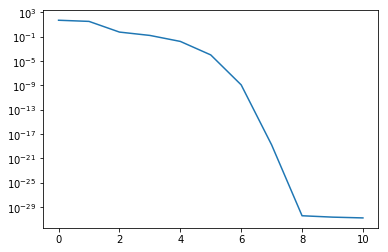

In [890]:
costs = []
gnorms = []
plus = oexp
m, c, gnorm = update_n(points_a, points_b, mstart, plus)
costs.append(c)
gnorms.append(gnorm)
for i in range(10):
    m, c, gnorm = update_n(points_a, points_b, m, plus)
    costs.append(c)
    gnorms.append(gnorm)
semilogy(costs)
print(m.rev() * m0)
print(m)

[ 26.0227  11.1898   9.7777 -13.3721 -14.9908  -7.1632]
[ 5.1497  2.2259  3.4949  3.9085 -6.666  -4.4639]
[ 0.2463 -0.4151 -2.1037  3.0437  0.6187 -0.4694]
[-0.0924  0.0169 -0.079   0.0836  0.1678  0.3804]
[ 0.0004  0.0007 -0.0018 -0.0009  0.0023 -0.0008]
[-0. -0. -0.  0.  0. -0.]
[-0. -0.  0.  0. -0.  0.]
[ 0. -0. -0. -0.  0. -0.]
[ 0. -0.  0.  0. -0. -0.]
[-0. -0. -0.  0. -0.  0.]
[-0. -0. -0.  0. -0.  0.]
Mot: [ 1 2.9e-17 3.5e-18 1.4e-17 1.4e-17 7.1e-17 1e-16 2.8e-17 ]
Mot: [ 0.98 -0.16 0.035 0.12 -0.049 -0.038 -0.055 0.0044 ]


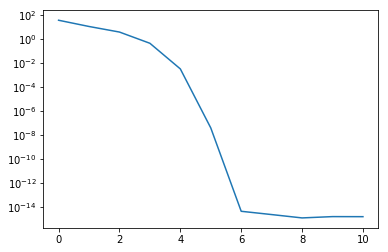

In [891]:
errs = []
gnorms = []
plus = oexp
m, c, gnorm = update_gn(points_a, points_b, mstart,plus)
errs.append(c)
gnorms.append(gnorm)
for i in range(10):
# while gnorm > 1e-6:
    m, c, gnorm = update_gn(points_a, points_b, m, plus)
    
    errs.append(c)
    gnorms.append(gnorm)
# semilogy(costs)
semilogy(gnorms)
print(m0.rev() * m)
print(m)

Mot: [ 1 0.0039 0.0016 -0.0021 -0.093 -0.085 -0.2 -0.00048 ]
Mot: [ 1 5.3e-15 2.6e-14 5e-14 4.5e-14 4.8e-14 -7.9e-14 -1.7e-18 ]


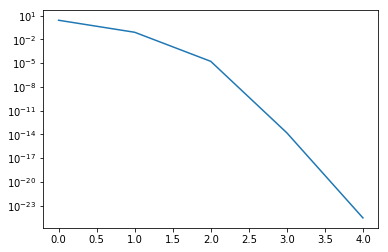

In [829]:
mes = MotorEstimationSolver(mstart)
for A, B in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(A,B)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
# mes.minimizer_type = 'LINE_SEARCH'
# mes.line_search_direction_type = 'STEEPEST_DESCENT'
# mes.line_search_direction_type = 'NONLINEAR_CONJUGATE_GRADIENT'
# mes.nonlinear_conjugate_gradient_type = 'HESTENES_STIEFEL'
# mes.line_search_type = 'ARMIJO'
# mes.max_num_iterations=20
(estimated_motor, summary, _) = mes.solve()
print(estimated_motor)
print(estimated_motor.rev() * m0)
# print(summary['full_report'])
semilogy(pd.DataFrame(summary['iterations'])['cost'])